In [6]:
import spacy
import textstat
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datasets import load_dataset

In [7]:
# Load spaCy model for syntactic parsing
dataset = load_dataset("mandarjoshi/trivia_qa", "rc", split="train")
print(dataset.shape)
print(dataset.column_names)

Resolving data files:   0%|          | 0/26 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/26 [00:00<?, ?it/s]

Loading dataset shards:   0%|          | 0/24 [00:00<?, ?it/s]

(138384, 6)
['question', 'question_id', 'question_source', 'entity_pages', 'search_results', 'answer']


In [8]:
import spacy
nlp = spacy.load("en_core_web_trf")

In [9]:

# dataset2 = load_dataset("akariasai/PopQA", split="test")
# print(dataset2.shape)
# print(dataset2.column_names)

# dataset2 = dataset2.map(lambda row: {'question_word_count': len(row['question'].split())})
# # Extract word counts
# word_counts = dataset2['question_word_count']

# # Display basic statistics
# print(f"Total Questions: {len(word_counts)}")
# print(f"Average Word Count: {sum(word_counts) / len(word_counts):.2f}")
# print(f"Max Word Count: {max(word_counts)}")
# print(f"Min Word Count: {min(word_counts)}")


# dataset = dataset.map(lambda row: {'question_word_count': len(row['question'].split())})
# # Extract word counts
# word_counts = dataset['question_word_count']

# # Display basic statistics
# print(f"Total Questions: {len(word_counts)}")
# print(f"Average Word Count: {sum(word_counts) / len(word_counts):.2f}")
# print(f"Max Word Count: {max(word_counts)}")
# print(f"Min Word Count: {min(word_counts)}")

In [10]:
questions = dataset['question']
logger = []

In [11]:
def syntax_tree_height_helper(token):
    if not list(token.children): # if the token has no children, it's a leaf
        return 1
    else:
        return 1 + max(syntax_tree_height_helper(child) for child in token.children)

def syntax_tree_height(sample_text, logger=None):
    try:
        doc = nlp(sample_text)
        token = [token for token in doc if token.dep_ == "ROOT"][0]
        return syntax_tree_height_helper(token)
    except Exception as e:
        if logger is not None:
            logger.append(e)
        return 1

In [18]:
# Compute sentence depth, sentence length, and readability scores
complexity_scores = {
    "dale_chall": [],
    "flesch_kincaid": [],
    "syntax_tree_height": [],
    "sentence_length": []
}
questions = questions[:100000]

for i, question in enumerate(questions):
    if i % 1000 == 0:
        print(f'processing question {i}')
    complexity_scores["dale_chall"].append(textstat.dale_chall_readability_score(question))
    complexity_scores["flesch_kincaid"].append(textstat.flesch_kincaid_grade(question))
    complexity_scores["syntax_tree_height"].append(syntax_tree_height(question))
    complexity_scores["sentence_length"].append(len(question.split()))

# Convert to DataFrame
df = pd.DataFrame(complexity_scores)
print(len(logger))

processing question 0


processing question 1000
processing question 2000
processing question 3000
processing question 4000
processing question 5000
processing question 6000
processing question 7000
processing question 8000
processing question 9000
processing question 10000
processing question 11000
processing question 12000
processing question 13000
processing question 14000
processing question 15000
processing question 16000
processing question 17000
processing question 18000
processing question 19000
processing question 20000
processing question 21000
processing question 22000
processing question 23000
processing question 24000
processing question 25000
processing question 26000
processing question 27000
processing question 28000
processing question 29000
processing question 30000
processing question 31000
processing question 32000
processing question 33000
processing question 34000
processing question 35000
processing question 36000
processing question 37000
processing question 38000
processing question 3

/tmp/ipykernel_3977207/467656907.py:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[0].set_xticklabels(mean_values.index, rotation=90)
/tmp/ipykernel_3977207/467656907.py:17: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[1].set_xticklabels(variance_values.index, rotation=90)


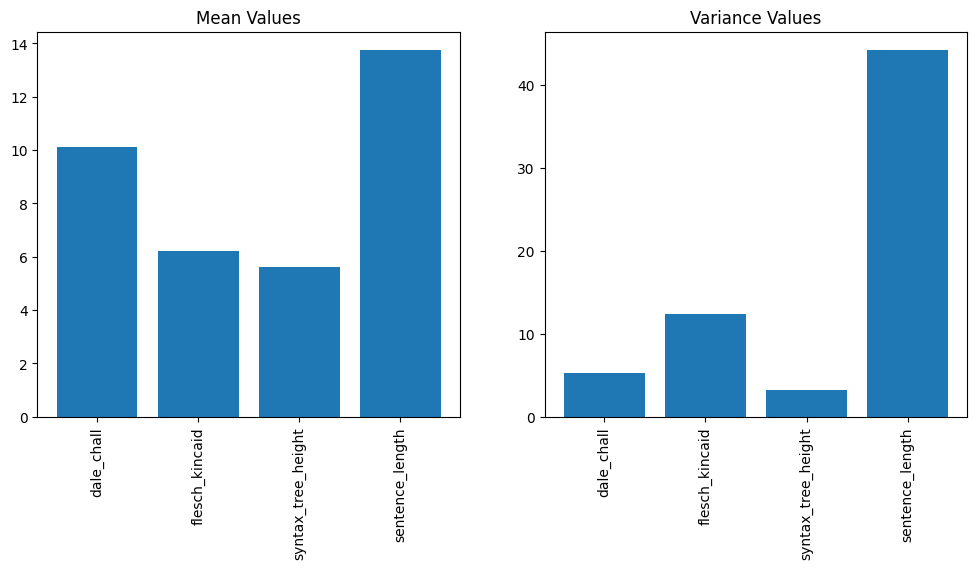

In [19]:
# Compute Correlation Matrix
correlation_matrix = df.corr()

# Compute Mean and Variance
mean_values = df.mean()
variance_values = df.var()

# Display Mean and Variance using Matplotlib
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

axes[0].bar(mean_values.index, mean_values.values)
axes[0].set_title("Mean Values")
axes[0].set_xticklabels(mean_values.index, rotation=90)

axes[1].bar(variance_values.index, variance_values.values)
axes[1].set_title("Variance Values")
axes[1].set_xticklabels(variance_values.index, rotation=90)

plt.show()

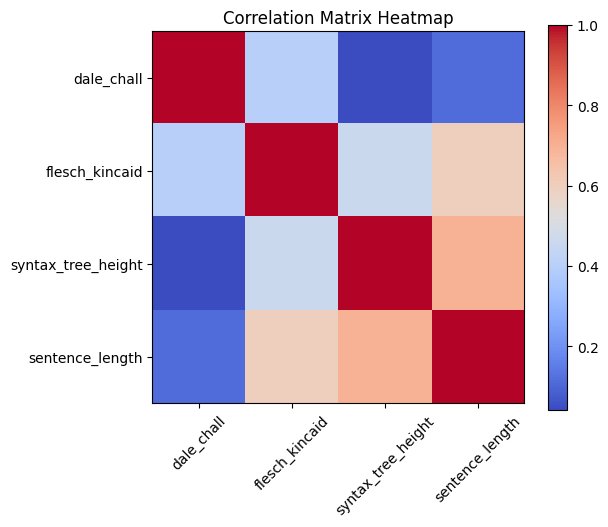

In [20]:
# Plot correlation heatmap
plt.figure(figsize=(6, 5))
plt.imshow(correlation_matrix, cmap='coolwarm', interpolation='nearest')
plt.colorbar()
plt.xticks(range(len(correlation_matrix.columns)), correlation_matrix.columns, rotation=45)
plt.yticks(range(len(correlation_matrix.columns)), correlation_matrix.columns)
plt.title("Correlation Matrix Heatmap")
plt.show()

/tmp/ipykernel_3977207/3237601092.py:15: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels(bucket_counts.index.astype(str), rotation=90, size=5)


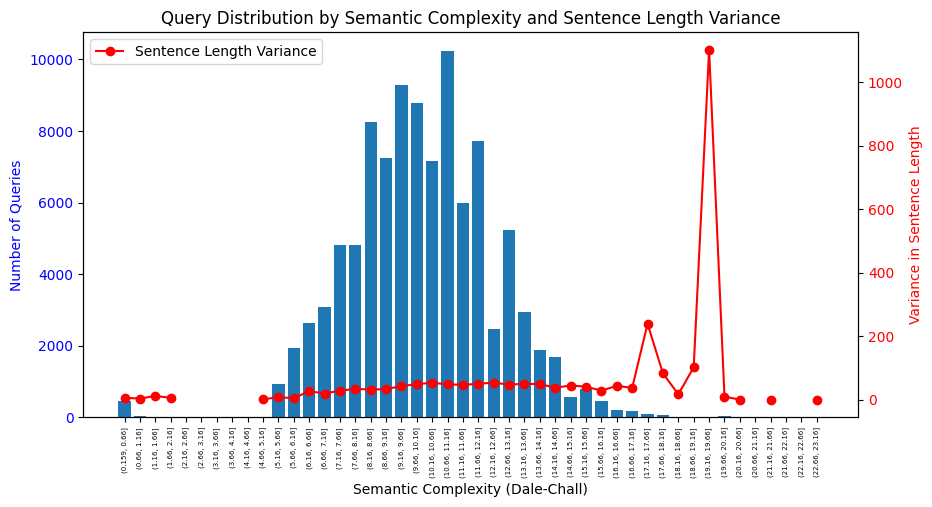

In [21]:
# Plot histogram of semantic complexity (bucket_dc width = 0.5)
bins = np.arange(min(df["dale_chall"]), max(df["dale_chall"]) + 0.5, 0.5)
df["bucket_dc"] = pd.cut(df["dale_chall"], bins=bins, include_lowest=True)

# Compute count per bucket and variance in sentence length per bucket
bucket_counts = df.groupby("bucket_dc")["sentence_length"].count()
bucket_variance = df.groupby("bucket_dc")["sentence_length"].var()

# Plot bar chart for number of queries in each bucket
fig, ax1 = plt.subplots(figsize=(10, 5))
ax1.bar(bucket_counts.index.astype(str), bucket_counts.values, label="Query Count")
ax1.set_xlabel("Semantic Complexity (Dale-Chall)")
ax1.set_ylabel("Number of Queries", color='b')
ax1.tick_params(axis='y', labelcolor='b')
ax1.set_xticklabels(bucket_counts.index.astype(str), rotation=90, size=5)

# Plot variance in sentence length as a line plot
ax2 = ax1.twinx()
ax2.plot(bucket_variance.index.astype(str), bucket_variance.values, color='r', marker='o', linestyle='-', label="Sentence Length Variance")
ax2.set_ylabel("Variance in Sentence Length", color='r')
ax2.tick_params(axis='y', labelcolor='r')

plt.title("Query Distribution by Semantic Complexity and Sentence Length Variance")
plt.legend()
plt.show()

/tmp/ipykernel_3977207/2570138800.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered_fk["bucket_fk"] = pd.cut(df_filtered_fk["flesch_kincaid"], bins=bins, include_lowest=True)


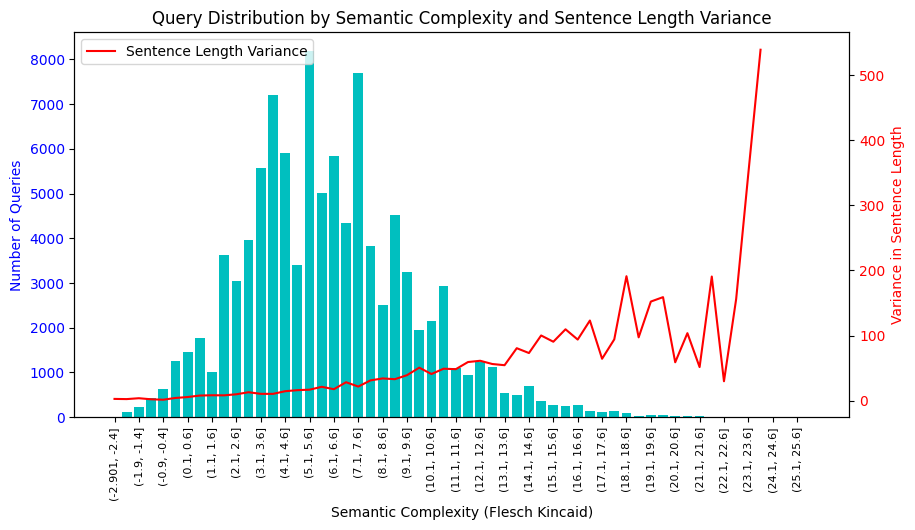

In [22]:
# Plot histogram of semantic complexity (bucket width = 0.5)
percentile_99_fk = df["sentence_length"].quantile(0.999)
df_filtered_fk = df[df["sentence_length"] <= percentile_99_fk]
bins = np.arange(min(df_filtered_fk["flesch_kincaid"]), max(df_filtered_fk["flesch_kincaid"]) + 0.5, 0.5)
df_filtered_fk["bucket_fk"] = pd.cut(df_filtered_fk["flesch_kincaid"], bins=bins, include_lowest=True)

# Compute count per bucket and variance in sentence length per bucket
bucket_counts = df_filtered_fk.groupby("bucket_fk")["sentence_length"].count()
bucket_variance = df_filtered_fk.groupby("bucket_fk")["sentence_length"].var()

# Plot bar chart for number of queries in each bucket
fig, ax1 = plt.subplots(figsize=(10, 5))
ax1.bar(bucket_counts.index.astype(str), bucket_counts.values, label="Query Count", color='c')
ax1.set_xlabel("Semantic Complexity (Flesch Kincaid)")
ax1.set_ylabel("Number of Queries", color='b')
ax1.tick_params(axis='y', labelcolor='b')
# ax1.set_xticklabels(bucket_counts.index.astype(str), rotation=90, size=5)
tick_positions = np.arange(0, len(bucket_counts.index), 2)
tick_labels = bucket_counts.index[tick_positions].astype(str)
ax1.set_xticks(tick_positions)  # Set tick positions
ax1.set_xticklabels(tick_labels, rotation=90, fontsize=8)  # Set tick labels

# Plot variance in sentence length as a line plot
ax2 = ax1.twinx()
ax2.plot(bucket_variance.index.astype(str), bucket_variance.values, color='r', label="Sentence Length Variance")
ax2.set_ylabel("Variance in Sentence Length", color='r')
ax2.tick_params(axis='y', labelcolor='r')

plt.title("Query Distribution by Semantic Complexity and Sentence Length Variance")
plt.legend()
plt.show()

/tmp/ipykernel_3977207/3555523067.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered_length["length_bucket"] = pd.cut(df_filtered_length["sentence_length"], bins=length_bins, include_lowest=True)


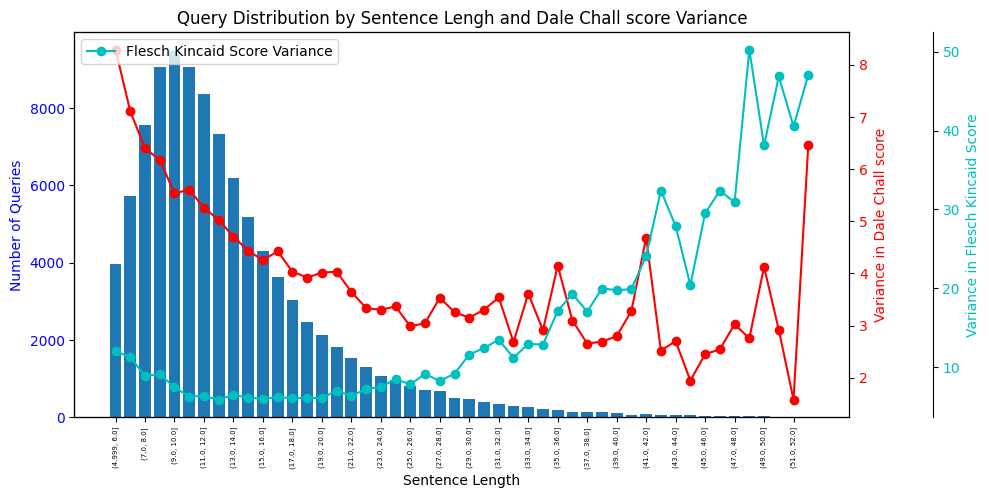

In [23]:
# Plot histogram of semantic complexity (bucket width = 0.5)
percentile_99_length = df["sentence_length"].quantile(0.999)
df_filtered_length  = df[df["sentence_length"] <= percentile_99_length]
length_bins = np.arange(min(df["sentence_length"]), max(df_filtered_length["sentence_length"]) + 1, 1)
df_filtered_length["length_bucket"] = pd.cut(df_filtered_length["sentence_length"], bins=length_bins, include_lowest=True)

# Compute count per bucket and variance in sentence length per bucket
length_bucket_counts = df_filtered_length.groupby("length_bucket")["dale_chall"].count()
length_bucket_variance = df_filtered_length.groupby("length_bucket")["dale_chall"].var()

# Plot bar chart for number of queries in each bucket
fig, ax1 = plt.subplots(figsize=(10, 5))
ax1.bar(length_bucket_counts.index.astype(str), length_bucket_counts.values, label="Query Count")
ax1.set_xlabel("Sentence Length")
ax1.set_ylabel("Number of Queries", color='b')
ax1.tick_params(axis='y', labelcolor='b')
# ax1.set_xticklabels(length_bucket_counts.index.astype(str), rotation=45)

tick_positions_length = np.arange(0, len(length_bucket_counts.index), 2)
tick_labels_length = length_bucket_counts.index[tick_positions_length].astype(str)
ax1.set_xticks(tick_positions_length)  # Set tick positions
ax1.set_xticklabels(tick_labels_length, rotation=90, fontsize=5)  # Set tick labels

# Plot variance in sentence length as a line plot
ax2 = ax1.twinx()
ax2.plot(length_bucket_variance.index.astype(str), length_bucket_variance.values, color='r', marker='o', linestyle='-', label="Dale Chall score Variance")
ax2.set_ylabel("Variance in Dale Chall score", color='r')
ax2.tick_params(axis='y', labelcolor='r')

length_bucket_variance_fk = df_filtered_length.groupby("length_bucket")["flesch_kincaid"].var()

# Plot variance in sentence length as a line plot
ax3 = ax1.twinx()
ax3.spines['right'].set_position(('outward', 60))
ax3.plot(length_bucket_variance_fk.index.astype(str), length_bucket_variance_fk.values, color='c', marker='o', linestyle='-', label="Flesch Kincaid Score Variance")
ax3.set_ylabel("Variance in Flesch Kincaid Score", color='c')
ax3.tick_params(axis='y', labelcolor='c')

plt.title("Query Distribution by Sentence Lengh and Dale Chall score Variance")
plt.legend()
plt.show()

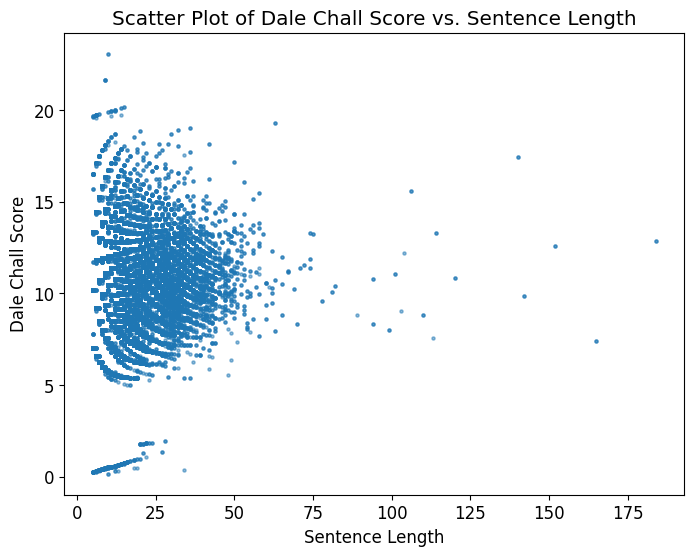

In [115]:
# Scatter plot of Flesch-Kincaid score against sentence length
plt.figure(figsize=(8, 6))
plt.scatter(df["sentence_length"], df["dale_chall"], alpha=0.5, s=5)
plt.xlabel("Sentence Length")
plt.ylabel("Dale Chall Score")
plt.title("Scatter Plot of Dale Chall Score vs. Sentence Length")
plt.show()


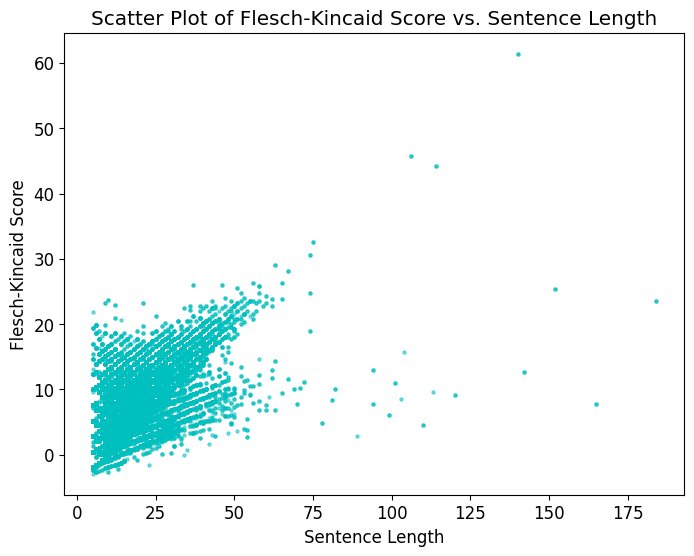

In [116]:
# Scatter plot of Flesch-Kincaid score against sentence length
plt.figure(figsize=(8, 6))
plt.scatter(df["sentence_length"], df["flesch_kincaid"], alpha=0.5, color='c', s=5)
plt.xlabel("Sentence Length")
plt.ylabel("Flesch-Kincaid Score")
plt.title("Scatter Plot of Flesch-Kincaid Score vs. Sentence Length")
plt.show()


In [ ]:
dataset2 = load_dataset("akariasai/PopQA", split="test")
print(dataset2.shape)
print(dataset2.column_names)

dataset2 = dataset2.map(lambda row: {'question_word_count': len(row['question'].split())})
# Extract word counts
word_counts = dataset2['question_word_count']

# Display basic statistics
print(f"Total Questions: {len(word_counts)}")
print(f"Average Word Count: {sum(word_counts) / len(word_counts):.2f}")
print(f"Max Word Count: {max(word_counts)}")
print(f"Min Word Count: {min(word_counts)}")